#

In [1]:
import pulp
import networkx as nx

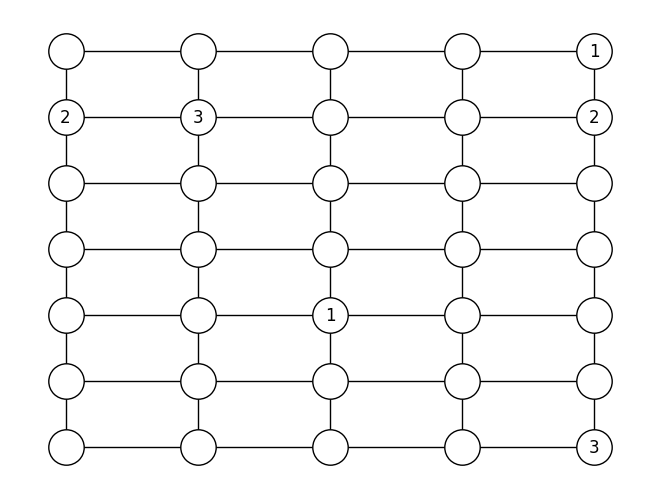

In [2]:
T = [
    ['','','','',1],
    [2,3,'','',2],
    ['','','','',''],
    ['','','','',''],
    ['','',1,'',''],
    ['','','','',''],
    ['','','','',3],
]

rows = len(T)
cols = len(T[0])

G = nx.grid_2d_graph(rows, cols) 
for r in range(rows):
    for c in range(cols):
        G.nodes[(r, c)]["value"] = T[r][c]
        G.nodes[(r, c)]["layer"] = c

nx.draw(G,pos=nx.multipartite_layout(G,subset_key="layer",align="vertical"),
          labels = nx.get_node_attributes(G,"value"),
          node_color="white",
          edgecolors="black",
          node_size=650)

In [3]:
# create problem
prob = pulp.LpProblem("numberlink", pulp.LpMaximize)

# define variables
x = pulp.LpVariable.dicts("x",(G.nodes(),[1,2,3]),cat=pulp.LpBinary)

# objective function
prob += 0

# each cell has a unique number
for (i,j) in G.nodes():
    prob += pulp.lpSum(x[(i,j)][k] for k in [1,2,3]) == 1
    
# enforce endpoints
for (i,j) in G.nodes():
    val = G.nodes[(i,j)]["value"]
    if val:
        prob += x[(i,j)][val] == 1
        
# if cell is an endpoint, then one neighbor must have same value
for (i,j) in G.nodes():
    val = G.nodes[(i,j)]["value"]
    if val:
        prob += pulp.lpSum(x[(u,v)][val] for (u,v) in G.neighbors((i,j))) == 1
        
# if cell is not an end point, then 2 neighbours must have same value
for (i,j) in G.nodes():
    val = G.nodes[(i,j)]["value"]
    if not val:
        for k in [1,2,3]:
            prob += pulp.lpSum(x[(u,v)][k] for (u,v) in G.neighbors((i,j))) >= 2-2*(1-x[(i,j)][k])
            prob += pulp.lpSum(x[(u,v)][k] for (u,v) in G.neighbors((i,j))) <= 2+2*(1-x[(i,j)][k])

In [4]:
prob.solve()

1

In [5]:
for (i,j) in G.nodes():
    for k in [1,2,3]:
        val = pulp.value(x[(i,j)][k])
        if val >0.9:
            G.nodes[(i,j)]["value"]=k

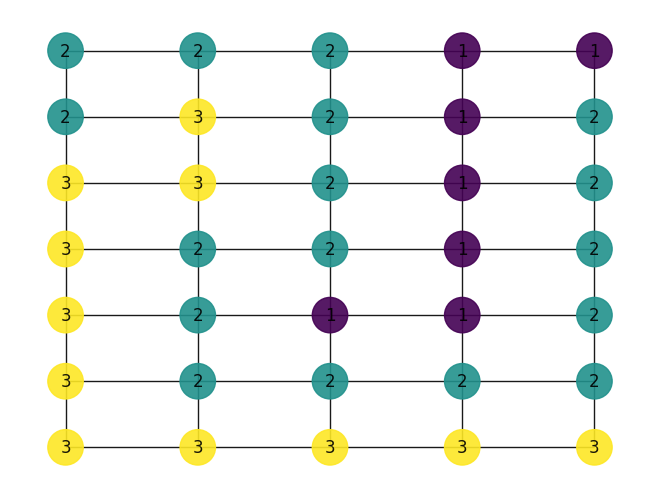

In [6]:
nx.draw(G,pos=nx.multipartite_layout(G,subset_key="layer"),
          labels = nx.get_node_attributes(G, 'value'),
          node_color=[G.nodes[(i,j)]["value"] for (i,j) in G.nodes()],
          node_size=650,
          alpha=0.9
       )